# ML on ESDC using PyTorch 
A DeepESDL example notebook

## Linear Regression for prediction of missing land surface temperature values from air temperature values
This notebook demonstrates how to implement Machine Learning on the Earth System Data Cube using the ML library PyTorch. The workflow is self-contained and based on a generic use case to showcase data loading, sampling strategies, model training, model evaluation and visualisation.

Please, also refer to the DeepESDL documentation and visit the platform's website for further information!

ScaDS.AI, 2023

**This notebook runs needs a python conda environment with pytorch and mlflow installed, please checkout the documentation for help on [changing the environment](https://deepesdl.readthedocs.io/en/v2022.12.1/guide/jupyterlab/). You can follow the MLFlow Experiment run via the bundled MLFlow UI.**

### Import necessary libraries

In [1]:
import os
import math
import torch
import mlflow
import numpy as np
import xarray as xr
import pandas as pd
import dask.array as da
from torch import nn
from global_land_mask import globe
from xcube.core.store import new_data_store
from matplotlib.colors import LinearSegmentedColormap
from torch.utils.data import TensorDataset, DataLoader

import logging
logging.getLogger('mlflow.utils.requirements_utils').setLevel(logging.ERROR)

# add path, if mltools not installed
import sys
sys.path.append('../mltools')

### Load Data (Earth System Data Cube)
We load the ESDC (*.zarr) from the s3 data store (lazy load). The ESDC consists of three dimensions (longitude, latitude, time). Out of many available cube variables, which are dask arrays, we load two ("land_surface_temperature", "air_temperature_2m"). 

In [2]:
data_store = new_data_store("s3", root="esdl-esdc-v2.1.1", storage_options=dict(anon=True))
dataset    = data_store.open_data('esdc-8d-0.083deg-184x270x270-2.1.1.zarr')
dataset    = xr.open_zarr('lst_small.zarr')
ds         = dataset[['land_surface_temperature', 'air_temperature_2m']]
ds

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Add land mask variable 
Here we exclude redundant water surface values for our use case and only consider solid Earth data for our ML analysis. We extend the ESDC by a new variable "land_mask". The mask is a data array initialized for one time slice of the ESDC. 

In [3]:
lon_grid, lat_grid = np.meshgrid(ds.lon,ds.lat)
lm0                = da.from_array(globe.is_land(lat_grid, lon_grid))
lm0

dask.array<array, shape=(2160, 4320), dtype=bool, chunksize=(2160, 4320), chunktype=numpy.ndarray>

We now extend the mask to all time slices of the ESDC.

In [4]:
lm = da.stack([lm0 for i in range(ds.sizes['time'])], axis = 0)
lm

dask.array<stack, shape=(10, 2160, 4320), dtype=bool, chunksize=(1, 2160, 4320), chunktype=numpy.ndarray>

We add the mask as variable to the ESDC. The cube now consists of three equally chunked variables ("land_surface_temperature", "air_temperature_2m", "land_mask"). 

In [5]:
from mltools.cube_utilities import get_chunk_sizes

xdsm = ds.assign(
    land_mask = (
        ['time','lat','lon'],
        lm.rechunk(
            chunks=([v for k,v in get_chunk_sizes(ds)])
        )
    )
)
xdsm

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Plot masked data for one time slice
To do that we convert the cube to a pandas dataframe.

In [6]:
df = xdsm.sel({'time' : '2002-05-21'}).to_dataframe()
df

land_surface_temperature  air_temperature_2m  \
lat        lon                                                         
 89.958333 -179.958333                       NaN          266.297180   
           -179.875000                       NaN          266.297180   
           -179.791667                       NaN          266.297180   
           -179.708333                       NaN          266.297180   
           -179.625000                       NaN          266.297180   
...                                          ...                 ...   
-89.958333  179.625000                       NaN          219.817398   
            179.708333                       NaN          219.817398   
            179.791667                       NaN          219.817398   
            179.875000                       NaN          219.817398   
            179.958333                       NaN          219.817398   

                             time  land_mask  
lat        lon                                
 89.958333 -179.958333 2002-05-21      False  
           -179.875000 2002-05-21      False  
           -179.791667 2002-05-21      False  
           -179.708333 2002-05-21      False  
           -179.625000 2002-05-21      False  
...                           ...        ...  
-89.958333  179.625000 2002-05-21       True  
            179.708333 2002-05-21       True  
            179.791667 2002-05-21       True  
            179.875000 2002-05-21       True  
            179.958333 2002-05-21       True  

[9331200 rows x 4 columns]

Air Temperature

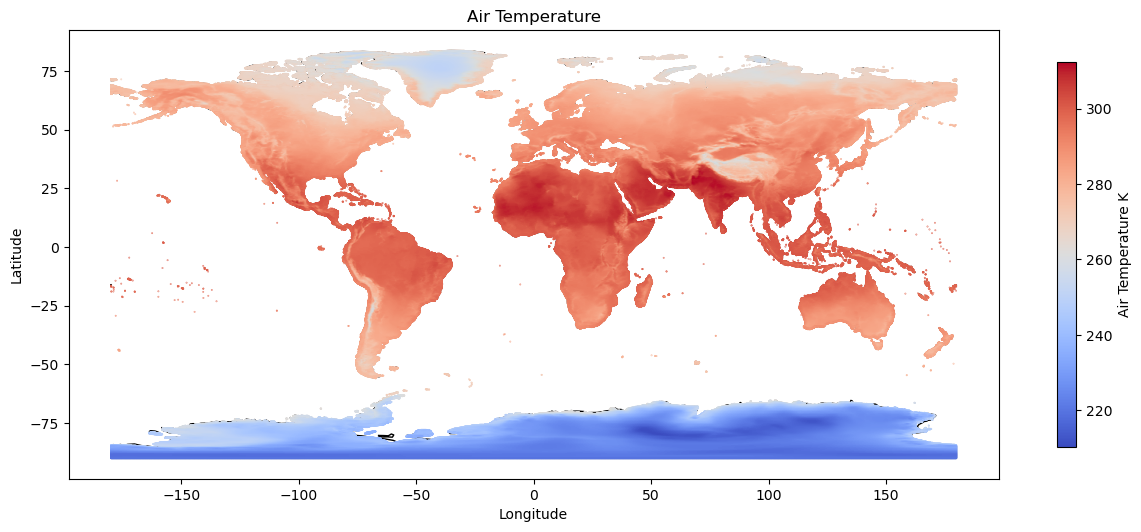

In [7]:
from mltools.geo_plots import plot_geo_data

dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

plot_geo_data(
    df             = dfdn,
    column_to_plot = 'air_temperature_2m',
    color_map      = 'coolwarm',
    title          = 'Air Temperature',
    label          = 'Air Temperature K'
)

Land Surface Temperature

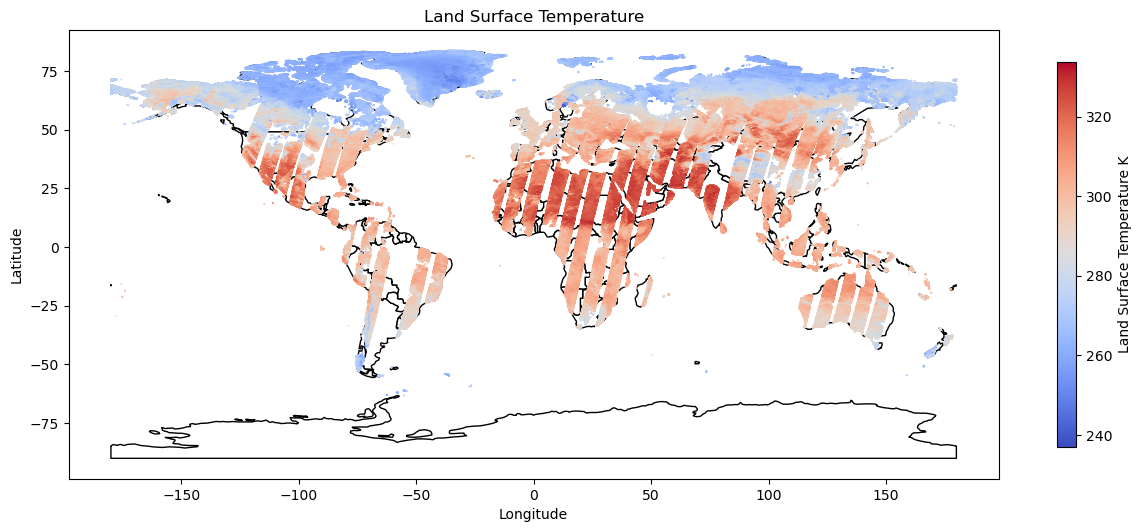

In [8]:
from mltools.geo_plots import plot_geo_data

plot_geo_data(
    df             = dfdn,
    column_to_plot = 'land_surface_temperature',
    color_map      = 'coolwarm',
    title          = 'Land Surface Temperature',
    label          = 'Land Surface Temperature K'
)

In [9]:
from mltools.data_assignment import assign_rand_split, assign_block_split

# random sampling
#xds = assign_rand_split(
#    ds    = xdsm,
#    split = 0.8
#)

# block sampling
xds = assign_block_split(
    ds         = xdsm,
    block_size = [("time", 10), ("lat", 100), ("lon", 100)],
    split      = 0.8
)
xds

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    split                     (time, lat, lon) float64 dask.array<chunksize=(10, 100, 100), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

Plot train/test assignment

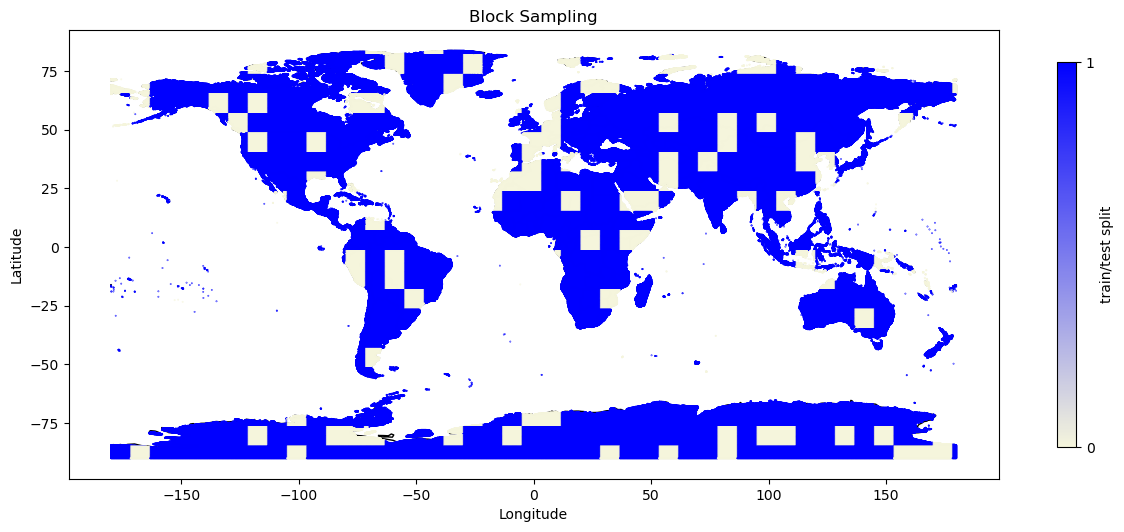

In [10]:
from mltools.geo_plots import plot_geo_data

df = xds.sel({'time' : '2002-05-21'}).to_dataframe()

dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

color_map = LinearSegmentedColormap.from_list("", ["beige","blue"])
plot_geo_data(
    df             = dfdn,
    column_to_plot = 'split',
    color_map      = color_map,
    title          = 'Block Sampling',
    label          = 'train/test split',
    ticks          = [0,1]
)

### Model set up

#### Select cuda device if available to use GPU ressources

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


#### Initialize MLFlow experiment

In [12]:
experiment_name = "Pytorch Linear Regression of LST from AT with mlflow"
mlflow.set_experiment(experiment_name)

current_experiment = dict(mlflow.get_experiment_by_name(experiment_name))
experiment_id      = current_experiment['experiment_id']

run_name = "ESDC_LR_block_0.1"
mlflow.autolog()

#### Train-/ and Test Set Creation and Preprocessing

We iterate through the chunks of the ESDC. The data will be preprocessed by flattening, choosing values, removing NaNs, normalization or standardization. Further, we will split the data into a training and testing fraction. We generate a train data loader and a test data loader and perform a linear regression. The train and test errors are returned during model training.

In [13]:
from mltools.datasets import XrDataset

dataset = XrDataset(ds=xds, num_chunks=2, rand_chunk=False).get_dataset()

Get range (min, max) and statistics (mean, std) of data variables for normalization or standardization.

In [14]:
from mltools.statistics import get_statistics, get_range

#at_range  = get_range(ds, 'air_temperature_2m')
#lst_range = get_range(ds, 'land_surface_temperature')

at_stat  = get_statistics(dataset, 'air_temperature_2m')
lst_stat = get_statistics(dataset, 'land_surface_temperature')

1
1


In [15]:
from mltools.statistics import standardize

X = standardize(dataset['air_temperature_2m'], *at_stat)
y = standardize(dataset['land_surface_temperature'], *lst_stat)

In [16]:
X_train, X_test = X[dataset['split'] == True], X[dataset['split'] == False]
y_train, y_test = y[dataset['split'] == True], y[dataset['split'] == False]

X_train = X_train.reshape(-1, 1)  # Making it [num_samples, 1]
y_train = y_train.reshape(-1, 1)  # Making it [num_samples, 1]
X_test  = X_test.reshape(-1, 1)
y_test  = y_test.reshape(-1, 1)

X_train.shape, y_train.shape

((102275, 1), (102275, 1))

In [17]:
from mltools.datasets import prepare_dataloader

train_ds     = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = prepare_dataloader(train_ds, batch_size=32, num_workers=5, parallel=False)
                
test_ds      = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
test_loader  = prepare_dataloader(test_ds, batch_size=32, num_workers=5, parallel=False)


#### Define model, loss and optimizer

In [18]:
lr     = 0.1
epochs = 10

reg_model = nn.Linear(in_features=1, out_features=1, bias=True)
mse_loss  = nn.MSELoss()
optimizer = torch.optim.SGD(reg_model.parameters(), lr=lr)

### Train model

In [19]:
from mltools.pt_training import Trainer

# Define the path for saving the best model and snapshots
best_model_path = './best_model.pth'

with mlflow.start_run(experiment_id=experiment_id, run_name = run_name) as run:
    
    mlflow.log_param('lr', lr)
    mlflow.log_param('number_epochs', epochs)

    # Trainer instance
    trainer = Trainer(
        model           = reg_model,
        train_data      = train_loader,
        test_data       = test_loader,
        optimizer       = optimizer,
        best_model_path = best_model_path,
        early_stopping  = True,
        patience        = 3,
        mlflow_run      = mlflow,
        epochs          = epochs
    )
    
    # Start training
    reg_model = trainer.train()

Epoch 0: Average Loss: 0.6060664862394333
Validation Loss: 5.5482e-01
New best model saved with validation loss: 0.5548162114069578
Epoch 1: Average Loss: 0.6060664848411791
Validation Loss: 5.5482e-01
New best model saved with validation loss: 0.5548162109679711
Epoch 2: Average Loss: 0.6060664861139882
Validation Loss: 5.5482e-01
Epoch 3: Average Loss: 0.6060664846523558
Validation Loss: 5.5482e-01
Epoch 4: Average Loss: 0.6060664848006754
Validation Loss: 5.5482e-01
Epoch 5: Average Loss: 0.6060664848254439
Validation Loss: 5.5482e-01
Stopping early due to no improvement.
Loaded best model weights.
Log best model weights.


### Model Predictions

Get Air Temperature values for Lon/Lat with missing Land Surface Temperature values

In [1]:
df = xds.sel({'time' : '2002-05-21'}).to_dataframe()
df

NameError: name 'xds' is not defined

Predict missing Land Surface Temperature values from Air Temperature values

In [21]:
from mltools.statistics import standardize, undo_standardizing

dfl     = df[df['land_mask'] == True]
orig    = dfl.dropna()
to_pred = dfl[np.isnan(dfl['land_surface_temperature'])]
output  = to_pred.drop('land_surface_temperature', axis = 1)

X = standardize(to_pred['air_temperature_2m'], *at_stat)
X = X.values

# Ensure X is a float32 tensor
X_tensor = torch.tensor(X.reshape(-1, 1), dtype=torch.float32).to(device)

# Use the tensor with the correct dtype when calling the model
lstp = reg_model(X_tensor)
output['land_surface_temperature'] = undo_standardizing(lstp.detach().cpu().numpy(), *lst_stat)
output

air_temperature_2m       time  land_mask  split  \
lat        lon                                                            
 83.208333 -73.958333           266.152954 2002-05-21       True    1.0   
 83.125000 -77.041667           265.867096 2002-05-21       True    1.0   
           -76.958333           265.832367 2002-05-21       True    1.0   
           -76.875000           265.832367 2002-05-21       True    1.0   
           -76.791667           265.832367 2002-05-21       True    1.0   
...                                    ...        ...        ...    ...   
-89.958333  179.625000          219.817398 2002-05-21       True    1.0   
            179.708333          219.817398 2002-05-21       True    1.0   
            179.791667          219.817398 2002-05-21       True    1.0   
            179.875000          219.817398 2002-05-21       True    1.0   
            179.958333          219.817398 2002-05-21       True    1.0   

                        land_surface_temperature  
lat        lon                                    
 83.208333 -73.958333                 272.598877  
 83.125000 -77.041667                 272.372437  
           -76.958333                 272.344940  
           -76.875000                 272.344940  
           -76.791667                 272.344940  
...                                          ...  
-89.958333  179.625000                235.897095  
            179.708333                235.897095  
            179.791667                235.897095  
            179.875000                235.897095  
            179.958333                235.897095  

[1739067 rows x 5 columns]

### Plot Predictions

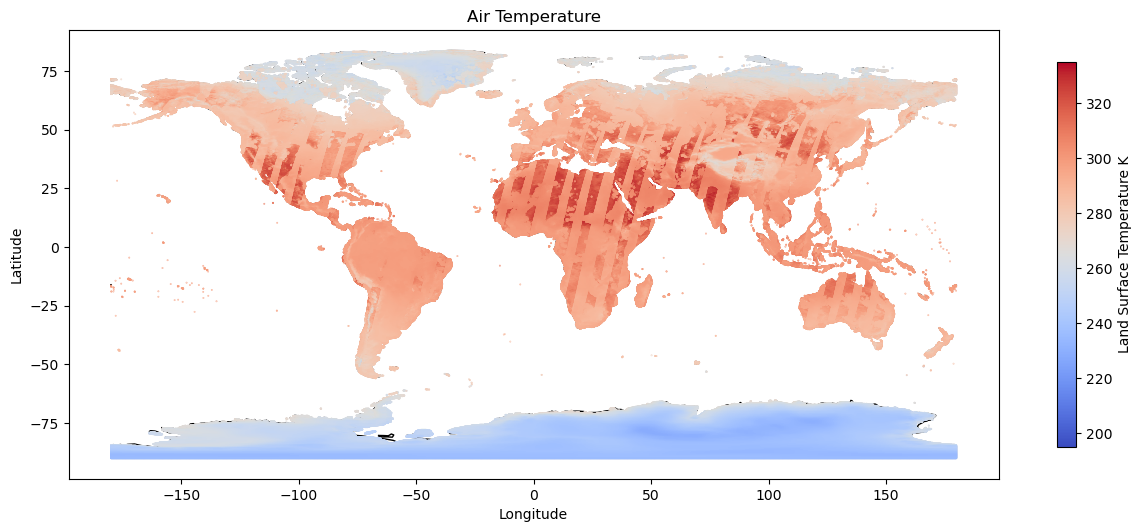

In [22]:
from mltools.geo_plots import plot_geo_data

df  = pd.concat([orig['land_surface_temperature'], output['land_surface_temperature']])
lst = df.reset_index()

plot_geo_data(
    df             = lst,
    column_to_plot = 'land_surface_temperature',
    color_map      = 'coolwarm',
    title          = 'Air Temperature',
    label          = 'Land Surface Temperature K', 
    vmin           = 195,
    vmax           = 335
)

### Save prediction as cube in s3-store

In [19]:
# select time slices (start, end)
ts = xds.sel(time=slice('2002-05-21', '2002-07-24'))
ts

<xarray.Dataset>
Dimensions:                   (time: 9, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-07-24
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(9, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(9, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(9, 270, 270), meta=np.ndarray>
    split                     (time, lat, lon) float64 dask.array<chunksize=(9, 100, 100), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

Calculate predictions

In [20]:
from mltools.statistics import standardize, undo_standardizing

df      = ts.to_dataframe()
dfl     = df[df['land_mask'] == True]
orig    = dfl.dropna()
to_pred = dfl[np.isnan(dfl['land_surface_temperature'])]
output  = to_pred.drop('land_surface_temperature', axis = 1)

X = standardize(to_pred['air_temperature_2m'], *at_stat)
X = X.values

X_tensor = torch.tensor(X.reshape(-1, 1), dtype=torch.float32).to(device)
lstp     = reg_model(X_tensor)

output['land_surface_temperature'] = undo_standardizing(lstp.detach().cpu().numpy(), *lst_stat)
output

air_temperature_2m  land_mask  split  \
time       lat        lon                                                 
2002-05-21  83.208333 -73.958333           266.152954       True    1.0   
            83.125000 -77.041667           265.867096       True    1.0   
                      -76.958333           265.832367       True    1.0   
                      -76.875000           265.832367       True    1.0   
                      -76.791667           265.832367       True    1.0   
...                                               ...        ...    ...   
2002-07-24 -89.958333  179.625000          220.299347       True    1.0   
                       179.708333          220.299347       True    1.0   
                       179.791667          220.299347       True    1.0   
                       179.875000          220.299347       True    1.0   
                       179.958333          220.299347       True    1.0   

                                   land_surface_temperature  
time       lat        lon                                    
2002-05-21  83.208333 -73.958333                 266.825348  
            83.125000 -77.041667                 266.479858  
                      -76.958333                 266.437866  
                      -76.875000                 266.437866  
                      -76.791667                 266.437866  
...                                                     ...  
2002-07-24 -89.958333  179.625000                211.405121  
                       179.708333                211.405121  
                       179.791667                211.405121  
                       179.875000                211.405121  
                       179.958333                211.405121  

[15015594 rows x 4 columns]

In [21]:
dfp = pd.concat([orig, output])


In [ ]:
xar = dfp.to_xarray()

Set metadata

In [ ]:
xar.attrs['date_created'] = '08.05.2023'
xar.attrs['source']       = 'Earth System Data Cube'
xar.attrs['project']      = 'ESA DeepESDL'
xar.attrs['title']        = 'Predicted land surface temperature'
xar.attrs['summary']      = 'Missing land surface temperature values predicted from air temperature values by linear regression'

xar.land_surface_temperature.attrs['unit'] = 'K'
xar.air_temperature_2m.attrs['unit']       = 'K'

In [ ]:
S3_USER_STORAGE_KEY    = os.environ["S3_USER_STORAGE_KEY"]
S3_USER_STORAGE_SECRET = os.environ["S3_USER_STORAGE_SECRET"]
S3_USER_STORAGE_BUCKET = os.environ["S3_USER_STORAGE_BUCKET"]

In [ ]:
from xcube.core.store import new_data_store
team_store = new_data_store("s3", 
                       root=S3_USER_STORAGE_BUCKET, 
                       storage_options=dict(
                           anon   = False,
                           key    = S3_USER_STORAGE_KEY,
                           secret = S3_USER_STORAGE_SECRET
                       ))

In [ ]:
team_store.write_data(xar,'Predicted_LST.zarr', replace=True)
